# Simulating non-linearity for Euclid Detectors
Started Jan 23rd.
By Shooby <br>
Last edited: Jan 29th <br>

---

### Nonlinearity in NIR detectors

> From Plazas et al. 2017: <br>
> Photon -> Charge -> Voltage -> ADU (Analog to Digital Unit)  <br>
> - At low fluxes (QE): Reciprocity failure, photon to charge)<br>
> - Capacitance variance (charge accumulates, depletion region narrows, capacitance increases --> different charge to voltage)
> - electronic chain non linearity, ROIC (Read Out Integrated Circuit)

> Correction for the latter two is usually done by a quadratic polynomial of type: V = C0 + C1*t + C2* (C1*t)^2


Peter's drawing on board: <br>
![title](ext/Peter_onboard.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip


class Dark:

    imsize = 2048
    refsize = 4
    saturation_lim = 65535.0
    pedest = 50 ## find about this Peter:500
    
    def __init__(self, flux= 19.0, ref= 4.0, readnoise=8.0, nread=400, tread=1.41):
        self.flux = flux
        self.ref = ref
        self.readnoise = readnoise
        self.nread = nread
        self.tread = tread
         
    def ref_pixels(self):
        '''A mask to facilitate indexing of the reference pixels, where
        every reference pixel is 1, and the rest of the pixel values are
        set to zero.'''    
        mask = np.zeros([self.imsize,self.imsize])        
        mask[:self.refsize,:]=1
        mask[:,:self.refsize]=1
        mask[self.imsize-self.refsize:,:]=1
        mask[:,self.imsize-self.refsize:]=1
        return mask
    
    def add_nonlinearity(self, i, coef = [0.01,1,0.01]):
        '''Each pixel in a frame gets the flux by multiplying the flux by the integration 
        time and the number of reads (i), except for the reference pixels around the edges.
        A fixed value of reference pixels is now implemented should be revised. A polynomial 
        is being subtracted for the non_linearity correction.'''    
        im =  np.zeros([self.imsize,self.imsize]) + self.ref
        im = im + i * self.tread * self.flux * (1.0-self.ref_pixels() )- self.ref * (1.0-self.ref_pixels())
        dark_im = im - (coef[0]*((coef[1]*i)**2) + coef[1]*i + coef[2])
        return dark_im
    
    def all_frames(self, coefs= [0.0001,1,0.1]):
        '''Make the dark image, adding detector non linearity, read noise 
        and a random pedestal''' 
        dark_im = np.zeros( [self.imsize, self.imsize, self.nread])
        for i in range(self.nread):
            dark_im[:,:,i] = self.add_nonlinearity(i, coef = coefs)
            pedestal = np.random.randint(self.pedest)  #set the random pedistal for this exposure
            dark_im[:,:,i] += pedestal #add the pedistal to all of the data including the reference pixels.
            # adding noise to all pixels
            dark_im[:,:,i] += np.random.randn(self.imsize,self.imsize) * self.readnoise
            # setting pixels above the saturation limit to the saturation limit.
            dark_im[dark_im>self.saturation_lim] = self.saturation_lim   
        return dark_im

    def MACC(self, ng = 4, nf = 16, coefs= [0.01,1,0.01]):
        '''To return up the ramp sampled groups(ng) of averaged 
        frames (nf). nd frames are droped between each group of
        averaged frames. MACC'''
        nd = (self.nread-(ng*nf))/(ng-1)
        dark_im = np.zeros( [self.imsize, self.imsize, ng])
        for i in range(ng):
            dark_group = np.zeros( [self.imsize, self.imsize, nf])
            for j in range(nf):
                frame = i*(nf+nd)+j
                dark_group[:,:,j] = self.add_nonlinearity(frame, coef = coefs)
                pedestal = np.random.randint(self.pedest)  #set the random pedistal for this exposure
                dark_group[:,:,j] += pedestal #add the pedistal to all of the data including the reference pixels.
                # adding noise to all pixels
                dark_group[:,:,j] += np.random.randn(self.imsize,self.imsize) * self.readnoise
                # setting pixels above the saturation limit to the saturation limit.
                dark_group[dark_group>self.saturation_lim] = self.saturation_lim   
            dark_group = dark_group.reshape(self.imsize*self.imsize,nf)
            d = np.mean(dark_group,axis=1)
            dark_im[:,:,i] = d.reshape(self.imsize,self.imsize)
        return dark_im
    
    def fit_quadratic_nl(self):
        '''To fit quadratic polynomial to the 3sigma clipped, 
        verage pixels of frames over time'''
        return coefs
    
    def plot_single_pixel_time(self, a,i_index,j_index, nf =16):
        '''how the flux of one pixel changes over frame/time'''
        y = a[i_index,j_index,:] 

        if np.shape(a)[2]==self.nread:
            x = np.arange(np.shape(a)[2])+0.5
            plt.plot(x,y,'k.', alpha=0.4,label='pixel = ['+str(i_index)+','+str(j_index)+']')

        else:
            nd = (self.nread-(np.shape(a)[2]*nf))/(np.shape(a)[2]-1)
            x = (nf+nd)*np.arange(np.shape(a)[2])+(nf/2)            
            plt.plot(x,y,'bo',label='MACC-pixel = ['+str(i_index)+','+str(j_index)+']')

        return y
    
    def plot_average_frame_time(self,a, clipping = False, clip_sigma = 3, nf=16):
        '''3sigma clipped average of a frame over time'''
        b = a.reshape(np.shape(a)[0]*np.shape(a)[1], np.shape(a)[2])
        if clipping: ## too slow if number of frames are large not recommended
            b = sigma_clip(b, sigma = clip_sigma, axis = 0, masked = False)
            
        y = np.nanmean(b, axis = 0) 
        
        if np.shape(a)[2]==self.nread:
            x = np.arange(np.shape(a)[2])+0.5
            plt.plot(x, y, 'k-', label = 'all-clipped average')
        else:
            nd = (self.nread-(np.shape(a)[2]*nf))/(np.shape(a)[2]-1)
            x = (nf+nd)*np.arange(np.shape(a)[2])+(nf/2)
            plt.plot(x, y, 'b-', label = 'MACC-clipped average')
            
        return y
    

In [2]:
first = Dark(flux=19.0, ref=4.0, readnoise=8.0, nread=400, tread=1.41)
a = first.all_frames(coefs= [0.01,1,0.01])
b = first.MACC(4, 16, coefs= [0.01,1,0.01])

Text(0, 0.5, 'Flux')

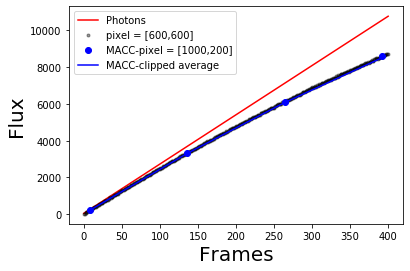

In [3]:
plt.plot([0,first.nread],[first.pedest,first.pedest+first.flux*first.tread*first.nread],'r-',label='Photons')

n = first.plot_single_pixel_time(a, 600, 600, nf =16)
#n = first.plot_average_frame_time(a, nf =16)

n = first.plot_single_pixel_time(b,1000,200, nf = 16)
n = first.plot_average_frame_time(b, nf =16)
plt.legend()
plt.xlabel(r'Frames',size=20)
plt.ylabel(r'Flux',size=20)

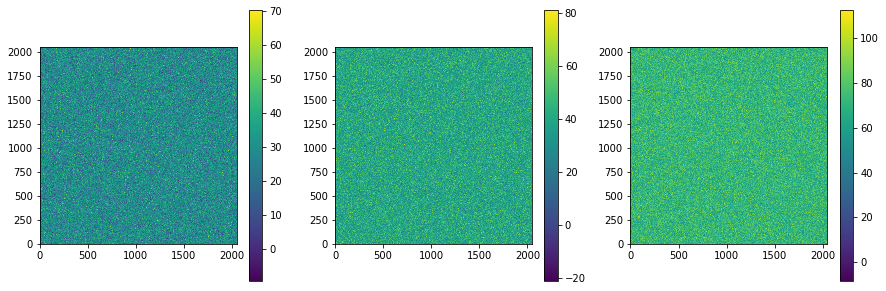

In [4]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(a[:,:,0], origin = 'lower')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(a[:,:,1], origin = 'lower')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(a[:,:,2] ,origin = 'lower')
plt.colorbar()

In [16]:
first = Dark(flux=19.0, ref=4.0, readnoise=8.0, nread=400, tread=1.41)


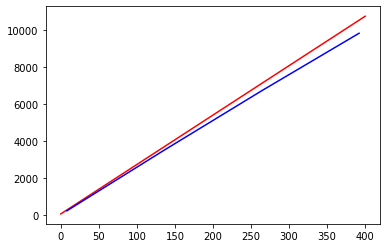

In [24]:
b = first.MACC(4, 16, coefs= [0.01,0.5,0.1])
plt.plot([0,first.nread],[first.pedest,first.pedest+first.flux*first.tread*first.nread],'r-',label='Photons')
n = first.plot_average_frame_time(b, nf =16)

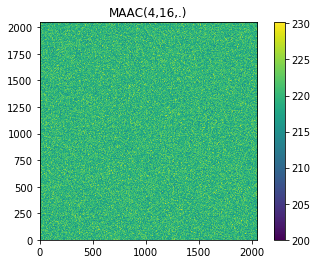

In [30]:
plt.title('MAAC(4,16,.)')
plt.imshow(b[:,:,0],vmin=200,origin='lower')
plt.colorbar()